# Dependencies and data loading

In [82]:
# %pip install "accelerate>=0.26.0"

In [83]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader
import torch
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize,
                                    RandomRotation,
                                    RandomResizedCrop,
                                    RandomHorizontalFlip,
                                    RandomAdjustSharpness,
                                    Resize, 
                                    ToTensor)
from transformers import ViTForImageClassification,ViTImageProcessor
import accelerate
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
import torch
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Add project root to path
sys.path.append('..')

# Data paths
DATA_DIR = '../../data/processed'

In [84]:

# Define paths
train_dir = os.path.join(DATA_DIR, 'train')
val_dir = os.path.join(DATA_DIR, 'val')

# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Load and label the training dataset
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

# Load and label the validation dataset
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 125 images belonging to 2 classes.


Found 27 images belonging to 2 classes.


In [85]:
images, labels = next(train_generator)
print(images.shape)

(32, 150, 150, 3)


# Preprocessing

In [86]:
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

In [87]:
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]
print("Size: ", size)

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            Resize((size, size)),
            RandomRotation(15),
            RandomAdjustSharpness(2),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize((size, size)),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

Size:  224


In [88]:
# Apply transforms to the train and validation datasets
def apply_transforms(generator, transform_fn):
	transformed_images = []
	transformed_labels = []
	for images, labels in generator:
		for i in range(len(images)):
			image = Image.fromarray((images[i] * 255).astype('uint8'))  # Convert to PIL Image
			transformed_image = transform_fn({'image': [image]})['pixel_values'][0]
			transformed_images.append(transformed_image)
			transformed_labels.append(labels[i])
		break  # Remove this line if you want to process the entire dataset
	return np.stack(transformed_images), np.array(transformed_labels)

train_images, train_labels = apply_transforms(train_generator, train_transforms)
val_images, val_labels = apply_transforms(val_generator, val_transforms)

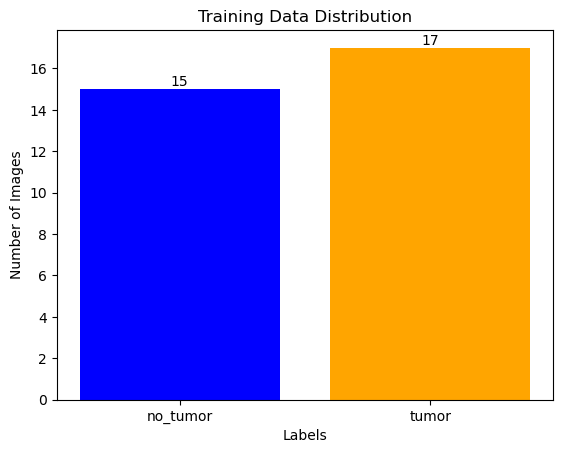

In [89]:
# Define label2id mapping
label2id = {0.0: 0, 1.0: 1}
id2label = {0.0: "no_tumor", 1.0: "tumor"}
# Count the occurrences of each label
unique, counts = np.unique(train_labels, return_counts=True)

# Plot the distribution
plt.bar([id2label[label] for label in unique], counts, color=['blue', 'orange'])
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=10)

plt.xlabel('Labels')
plt.ylabel('Number of Images')
plt.title('Training Data Distribution')
plt.show()

In [90]:
# Convert train and validation data into a format compatible with DataLoader
train_data = [{"pixel_values": torch.tensor(image), "label": label} for image, label in zip(train_images, train_labels)]
val_data = [{"pixel_values": torch.tensor(image), "label": label} for image, label in zip(val_images, val_labels)]

# Define collate function
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([label2id[example["label"]] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

# Create DataLoaders
train_dataloader = DataLoader(train_data, collate_fn=collate_fn, batch_size=4)
val_dataloader = DataLoader(val_data, collate_fn=collate_fn, batch_size=4)

In [91]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


In [92]:
batch = next(iter(val_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


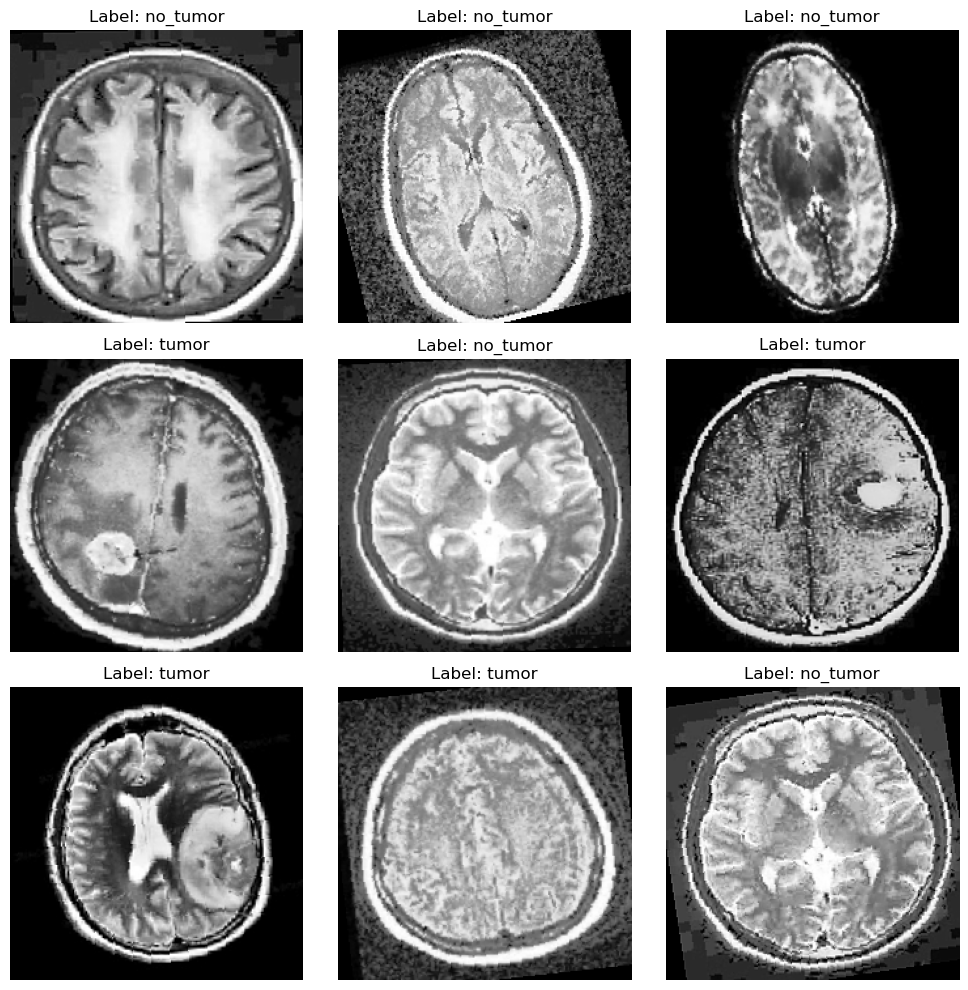

In [93]:
# Display the first image from the training dataset
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow((train_images[i].transpose(1, 2, 0) * 0.5 + 0.5))  # Denormalize and convert from (C, H, W) to (H, W, C)
    ax.set_title(f"Label: {id2label[train_labels[i]]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

# Model loading + fine tuning

In [94]:
# Load the model with the corrected mappings
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  id2label=id2label,
                                                  label2id=label2id)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [95]:

metric_name = "accuracy"

args = TrainingArguments(
    "checkpoints",
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=5e-5,  # Increased learning rate
    per_device_train_batch_size=8,  # Reduced batch size for better gradient updates from 32 to 16
    per_device_eval_batch_size=8,  # Increased evaluation batch size from 4 to 8
    num_train_epochs=20,  
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
    report_to="tensorboard",
)

In [96]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.argmax(axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }

# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     predictions = np.argmax(predictions, axis=1)
#     return dict(accuracy=accuracy_score(predictions, labels))

In [97]:
from transformers import set_seed

# Set the random seed for reproducibility
set_seed(62)

trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=val_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    processing_class=processor,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.001)]
)

# Running and model evaluation

In [98]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.673558,0.592593,0.666667,0.550000,0.846154
2,No log,0.637295,0.666667,0.727273,0.600000,0.923077
3,No log,0.597637,0.629630,0.687500,0.578947,0.846154
4,No log,0.561749,0.666667,0.709677,0.611111,0.846154
5,No log,0.538850,0.666667,0.689655,0.625000,0.769231


TrainOutput(global_step=20, training_loss=0.442046594619751, metrics={'train_runtime': 138.4174, 'train_samples_per_second': 4.624, 'train_steps_per_second': 0.578, 'total_flos': 1.239871833833472e+16, 'train_loss': 0.442046594619751, 'epoch': 5.0})

In [112]:
trainer.state.log_history

[{'eval_loss': 0.6735584139823914,
  'eval_accuracy': 0.5925925925925926,
  'eval_f1': 0.6666666666666666,
  'eval_precision': 0.55,
  'eval_recall': 0.8461538461538461,
  'eval_runtime': 4.812,
  'eval_samples_per_second': 5.611,
  'eval_steps_per_second': 0.831,
  'epoch': 1.0,
  'step': 4},
 {'eval_loss': 0.6372948288917542,
  'eval_accuracy': 0.6666666666666666,
  'eval_f1': 0.7272727272727273,
  'eval_precision': 0.6,
  'eval_recall': 0.9230769230769231,
  'eval_runtime': 4.8122,
  'eval_samples_per_second': 5.611,
  'eval_steps_per_second': 0.831,
  'epoch': 2.0,
  'step': 8},
 {'eval_loss': 0.5976372361183167,
  'eval_accuracy': 0.6296296296296297,
  'eval_f1': 0.6875,
  'eval_precision': 0.5789473684210527,
  'eval_recall': 0.8461538461538461,
  'eval_runtime': 5.4696,
  'eval_samples_per_second': 4.936,
  'eval_steps_per_second': 0.731,
  'epoch': 3.0,
  'step': 12},
 {'eval_loss': 0.5617493987083435,
  'eval_accuracy': 0.6666666666666666,
  'eval_f1': 0.7096774193548387,
  'e

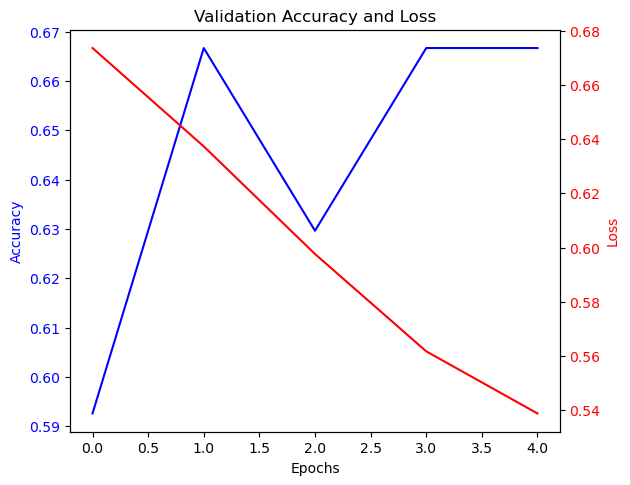

In [100]:
# Extract training and validation accuracy from trainer's logs
train_logs = trainer.state.log_history
eval_accuracy = [log["eval_accuracy"] for log in train_logs if "eval_accuracy" in log]
eval_loss = [log["eval_loss"] for log in train_logs if "eval_loss" in log]

# Plotting eval accuracy and eval loss
fig, ax1 = plt.subplots()

color = 'blue'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(eval_accuracy, color=color, label='Accuracy')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'red'
ax2.set_ylabel('Loss', color=color)
ax2.plot(eval_loss, color=color, label='Loss')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # to prevent overlap of labels
plt.title('Validation Accuracy and Loss')
plt.show()

In [101]:
# Save the trained model and tokenizer
model.save_pretrained("saved_model")
processor.save_pretrained("saved_model")

['saved_model\\preprocessor_config.json']

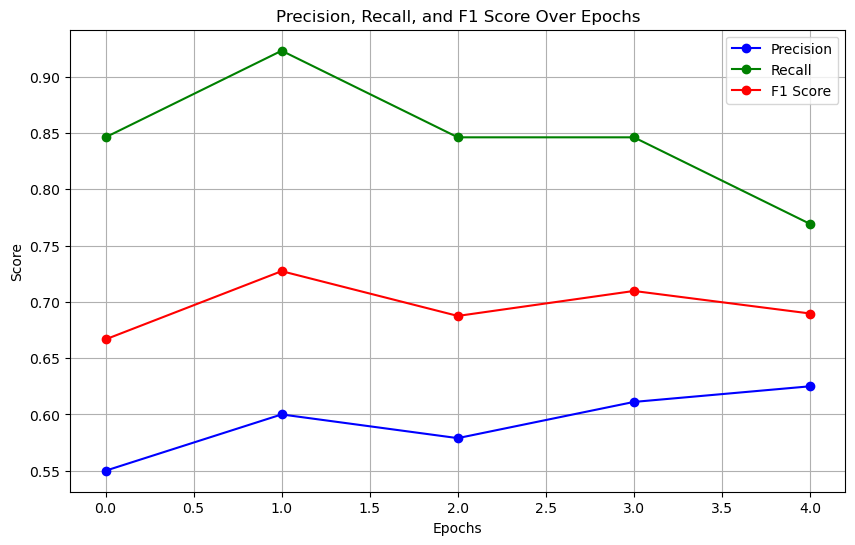

In [102]:
# Extract precision, recall, and F1 score from trainer's logs
eval_precision = [log["eval_precision"] for log in train_logs if "eval_precision" in log]
eval_recall = [log["eval_recall"] for log in train_logs if "eval_recall" in log]
eval_f1 = [log["eval_f1"] for log in train_logs if "eval_f1" in log]

# Plotting precision, recall, and F1 score
plt.figure(figsize=(10, 6))
plt.plot(eval_precision, label='Precision', marker='o', color='blue')
plt.plot(eval_recall, label='Recall', marker='o', color='green')
plt.plot(eval_f1, label='F1 Score', marker='o', color='red')

plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [103]:
test_dir = os.path.join(DATA_DIR, 'test')

test_datagen = ImageDataGenerator(rescale=1./255)


# Load and label the validation dataset
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 27 images belonging to 2 classes.


In [104]:
test_images, test_labels = apply_transforms(test_generator, val_transforms)

test_data = [{"pixel_values": torch.tensor(image), "label": label} for image, label in zip(test_images, test_labels)]

In [105]:
outputs = trainer.predict(test_data)

In [106]:
print(outputs.metrics)

{'test_loss': 0.630492091178894, 'test_accuracy': 0.7037037037037037, 'test_f1': 0.7647058823529411, 'test_precision': 0.6190476190476191, 'test_recall': 1.0, 'test_runtime': 5.0449, 'test_samples_per_second': 5.352, 'test_steps_per_second': 0.793}


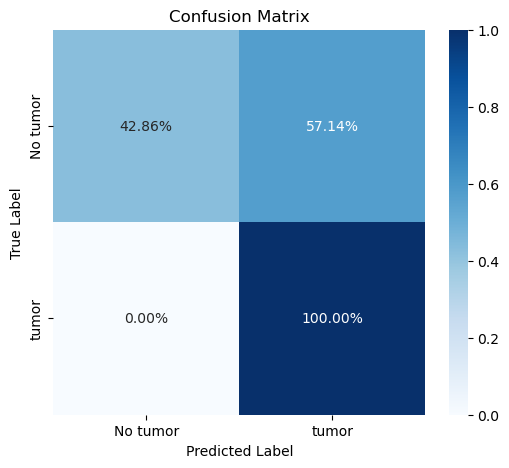

In [107]:
import seaborn as sns
labels = ["No tumor", "tumor"]
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)
cm = confusion_matrix(y_true, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize by row
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt=".2%", cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

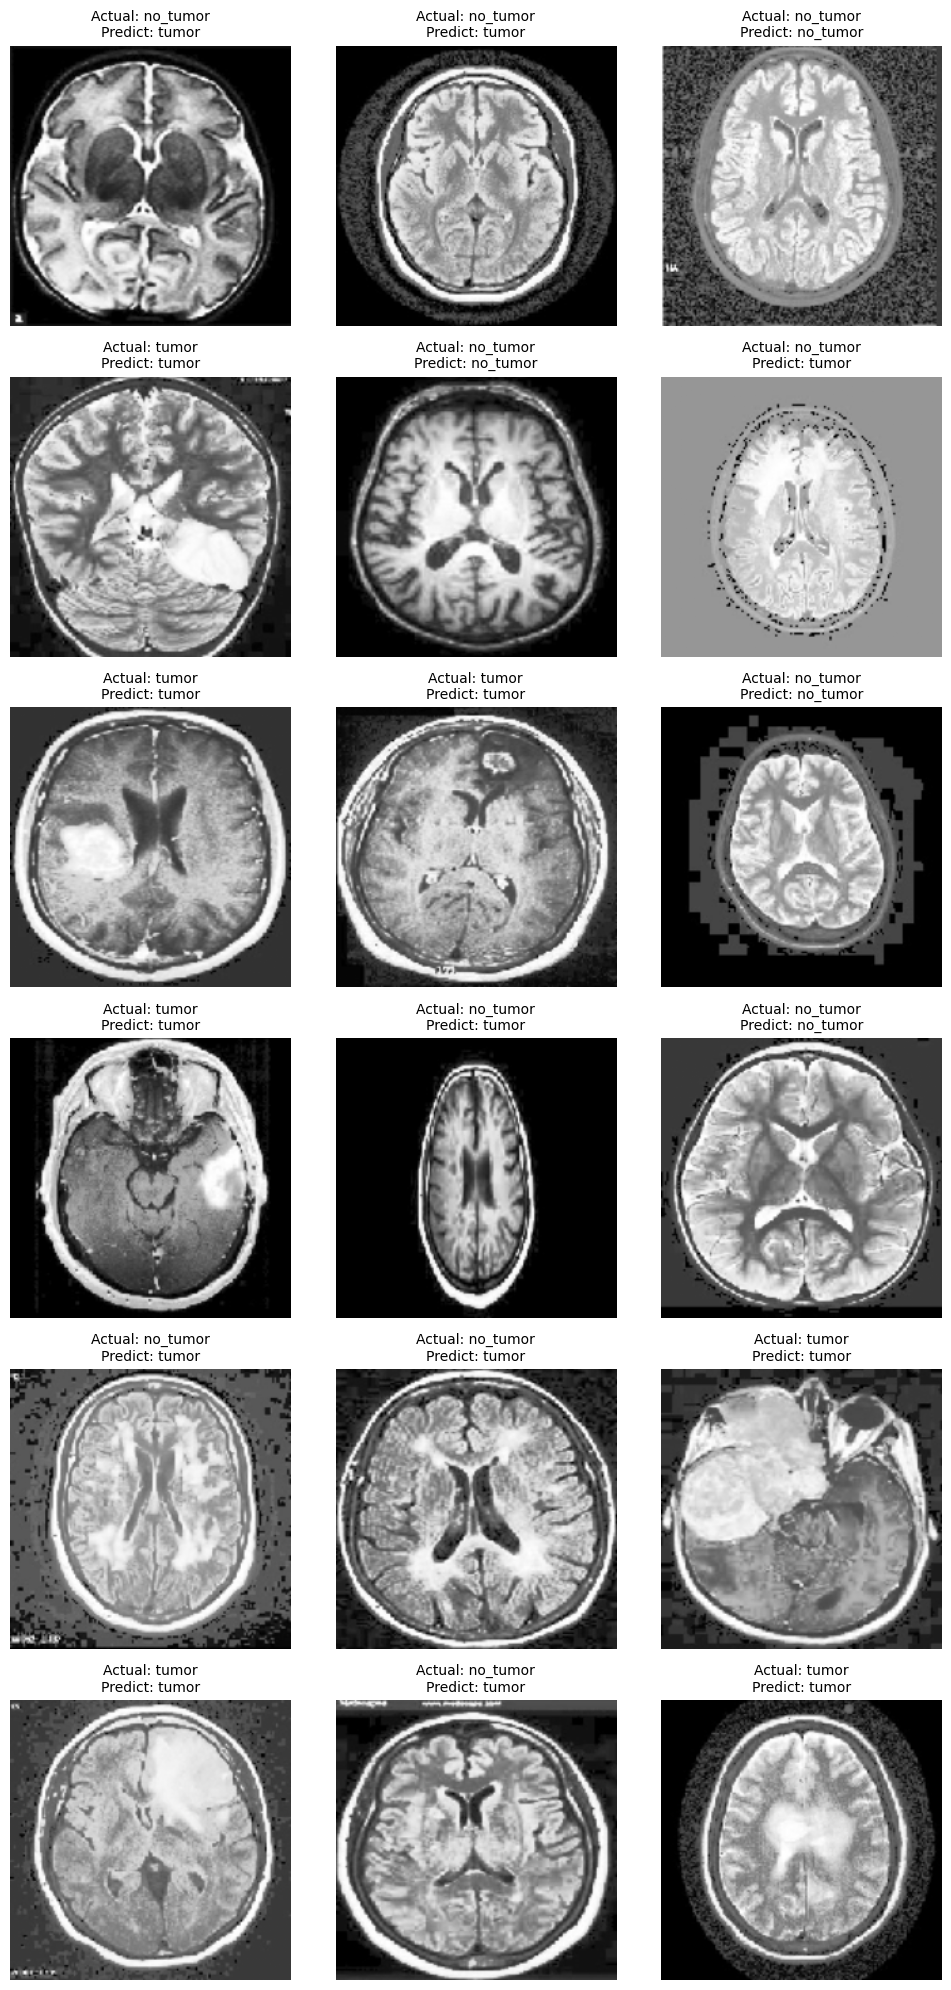

In [108]:
# Generate predictions
y_pred_classes = outputs.predictions.argmax(axis=1)  # Get predicted class indices

# Plot images with actual and predicted labels
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(10, 20))
axes = axes.flatten()

for index, (image, label) in enumerate(zip(test_images, test_labels)):
    # Convert image tensor to numpy array and denormalize
    image = image.transpose(1, 2, 0) * 0.5 + 0.5  # Convert from (C, H, W) to (H, W, C) and denormalize
    actual_class = "no_tumor" if label == 0 else "tumor"
    predicted_class = id2label[y_pred_classes[index]]
    if index >= len(axes):
        break
    # Display the image
    ax = axes[index]
    ax.imshow(image)
    ax.set_title(f'Actual: {actual_class}\nPredict: {predicted_class}', fontsize=10)
    ax.axis('off')

# Hide any unused subplots
for ax in axes[len(test_images):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


# Testing image from the internet

In [109]:
TEST_DATA_DIR = "C:/Users/sndp_/Downloads/"
test_dir = os.path.join(TEST_DATA_DIR, 'tumor_images')

test_datagen = ImageDataGenerator(rescale=1./255)


# Load and label the validation dataset
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_images, test_labels = apply_transforms(test_generator, val_transforms)

test_data = [{"pixel_values": torch.tensor(image), "label": label} for image, label in zip(test_images, test_labels)]



Found 2 images belonging to 1 classes.


In [110]:
outputs = trainer.predict(test_data)

c:\Users\sndp_\anaconda3\envs\deep-learning-sem4\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


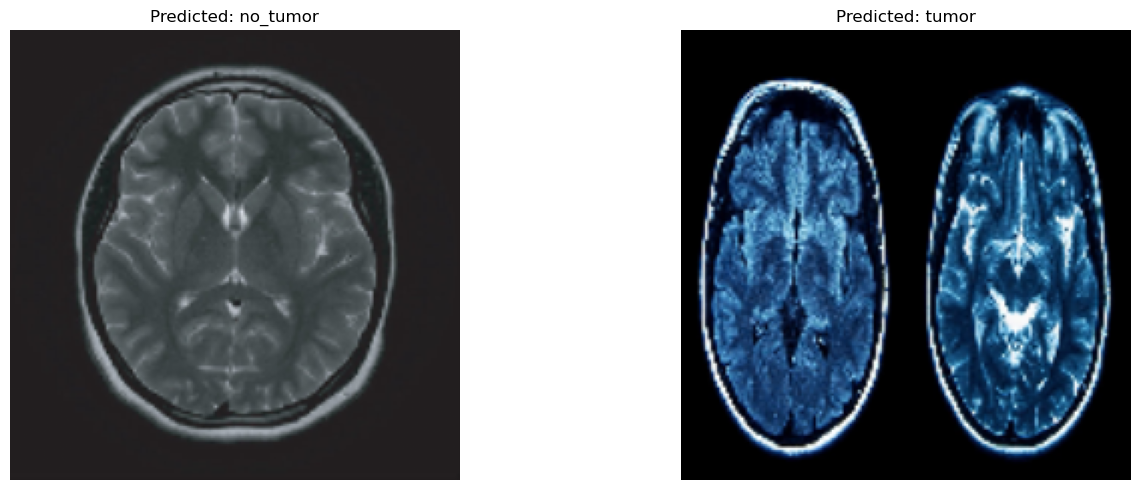

In [111]:
# Extract predictions
predictions = outputs.predictions

# Get the predicted class for each input
predicted_classes = predictions.argmax(axis=1)

# Map the predicted class indices to their corresponding labels
predicted_labels = [id2label[class_idx] for class_idx in predicted_classes]

# Display the predictions
# Display the image and the predicted label together
fig, axes = plt.subplots(1, len(test_images), figsize=(15, 5))
for i, ax in enumerate(axes):
    # Convert image tensor to numpy array and denormalize
    image = test_images[i].transpose(1, 2, 0) * 0.5 + 0.5  # Convert from (C, H, W) to (H, W, C) and denormalize
    ax.imshow(image)
    ax.set_title(f"Predicted: {predicted_labels[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()